## Basic NLP on Disaster Tweets

This is a getting started competition of predicting whether a tweet is actually referring to real disasters.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from pathlib import Path

plt.rcParams.update({'font.size': 14})

TRAIN_P = Path('/kaggle/input/nlp-getting-started/train.csv')
TEST_P  = Path('/kaggle/input/nlp-getting-started/test.csv')
SUB_P   = Path('/kaggle/input/nlp-getting-started/sample_submission.csv')

train = pd.read_csv(TRAIN_P)
test  = pd.read_csv(TEST_P)
sub   = pd.read_csv(SUB_P)

# 0-2) test에 'target'이 있으면 바로 실패 처리 (가장 흔한 누출)
assert 'target' not in test.columns, "TEST SET에 target 컬럼이 있습니다. 라벨 누출!"

## 1. Basic Exploration

In [2]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.duplicated().sum()

0

There are 52 duplicated rows. The duplicates will be removed.

In [4]:
train = train.drop_duplicates().reset_index(drop=True)

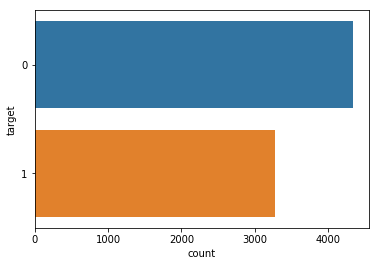

In [5]:
# Class balance
# train.target.value_counts()
sns.countplot(y=train.target);

In [6]:
# NA data
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Text is all non-null. Only a small percentage of tweets have no keyword. Location has much more null values.

## 2. Keywords

In [8]:
# Check number of unique keywords, and whether they are the same for train and test sets
print (train.keyword.nunique(), test.keyword.nunique())
print (set(train.keyword.unique()) - set(test.keyword.unique()))

221 221
set()


Train and test have the same set of keywords

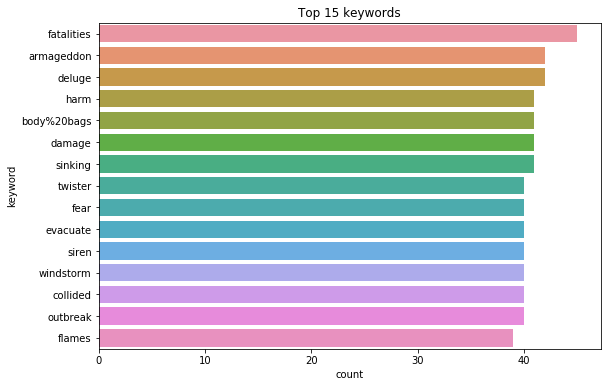

In [9]:
# Most common keywords
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()
# train.keyword.value_counts().head(10)

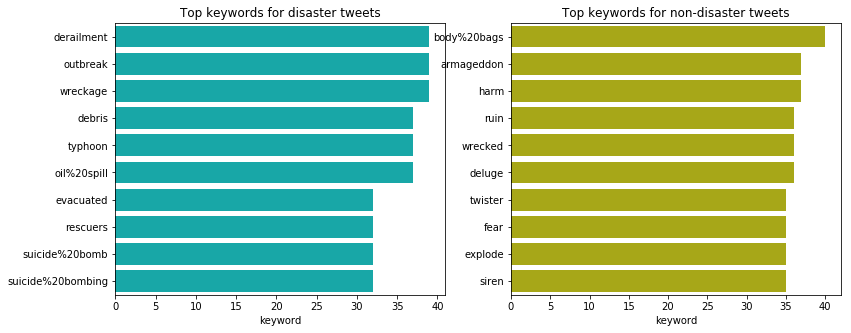

In [10]:
kw_d = train[train.target==1].keyword.value_counts().head(10)
kw_nd = train[train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

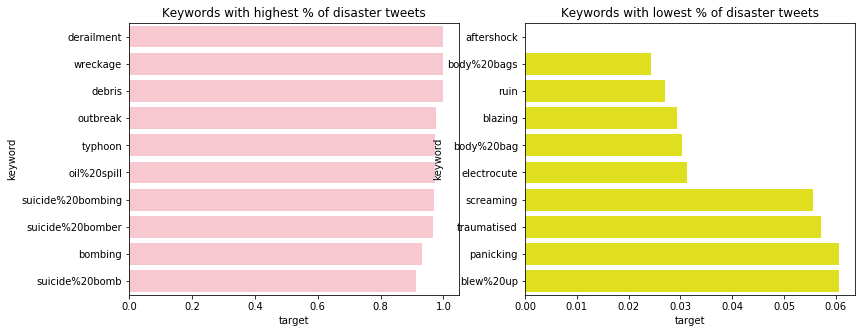

In [11]:
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='pink')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='yellow')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

## 3. Locations

In [12]:
# Check number of unique keywords and locations
print (train.location.nunique(), test.location.nunique())

3341 1602


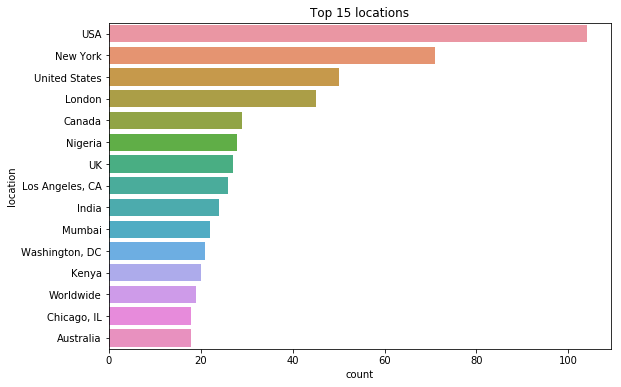

In [13]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster tweets for common locations.

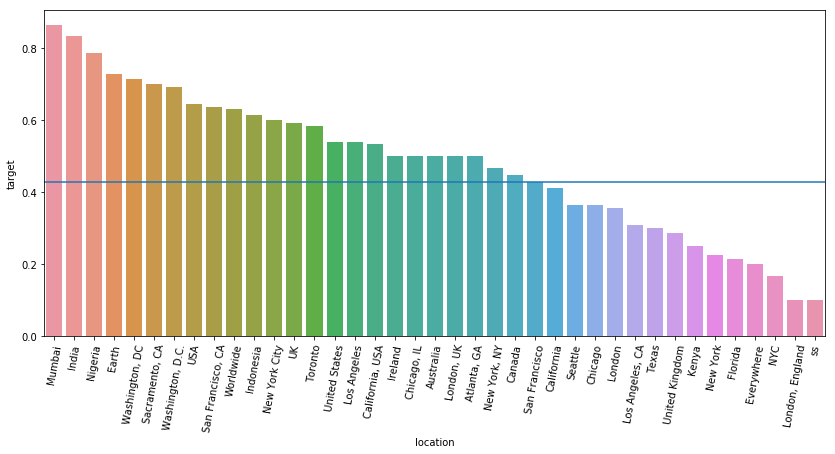

In [14]:
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

The top 3 locations with highest % of disaster tweets are **Mumbai, Inida, and Nigeria**. As the location data is not clean, we see some interesting cases, such as **'London, UK' saw a higher-than-average % of disaster tweets, but 'London' is below average**. We try to clean up the location and see if there is any difference:

In [15]:
# Fill NA values
for col in ['keyword','location']:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train['location_clean'] = train['location'].apply(lambda x: clean_loc(str(x)))
test['location_clean'] = test['location'].apply(lambda x: clean_loc(str(x)))

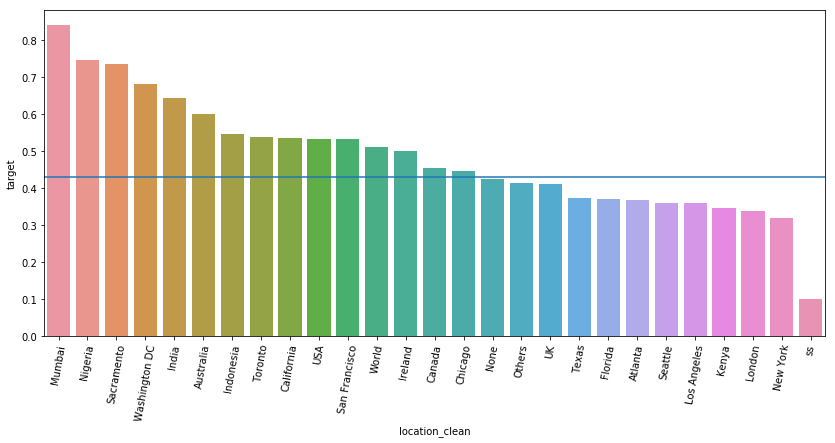

In [16]:
top_l2 = train.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

Mumbai and Nigeria are still on the top. Other than the strange 'ss', London and New York made the bottom of % of disaster tweets.

In [17]:
leak = pd.read_csv("../input/disasters-on-social-media/socialmedia-disaster-tweets-DFE.csv", encoding='latin_1')
leak['target'] = (leak['choose_one']=='Relevant').astype(int)
leak['id'] = leak.index
leak = leak[['id', 'target','text']]
merged_df = pd.merge(test, leak, on='id')
sub1 = merged_df[['id', 'target']]
sub1.to_csv('submit_1.csv', index=False)

## 5. Clean up Text Column

Here we clean up the text column by:
- Making a 'clean' text column, removing links and unnecessary white spaces
- Creating separate columns containing lists of hashtags, mentions, and links

In [18]:
import re

test_str = train.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [19]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(train)
test = process_text(test)

## 6. Create statistics from texts

In [20]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

print(train.shape, test.shape)

(7613, 19) (3263, 18)


In [21]:
train.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

All of the statistics have very low correlation with the target variable

## 7. Most frequent words and bigrams

What are the most common unigrams (single word) and bigrams (two-word sequence)?

In [22]:
from nltk import FreqDist, word_tokenize

# Make a set of stop words
stopwords = set(STOPWORDS)
# more_stopwords = {'https', 'amp'}
# stopwords = stopwords.union(more_stopwords)

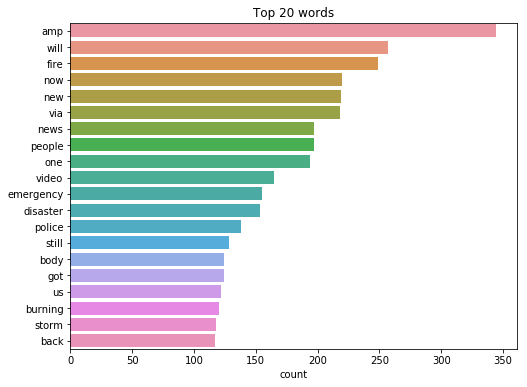

In [23]:
# Unigrams
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

We try to distinguish disaster and non-disaster tweets:

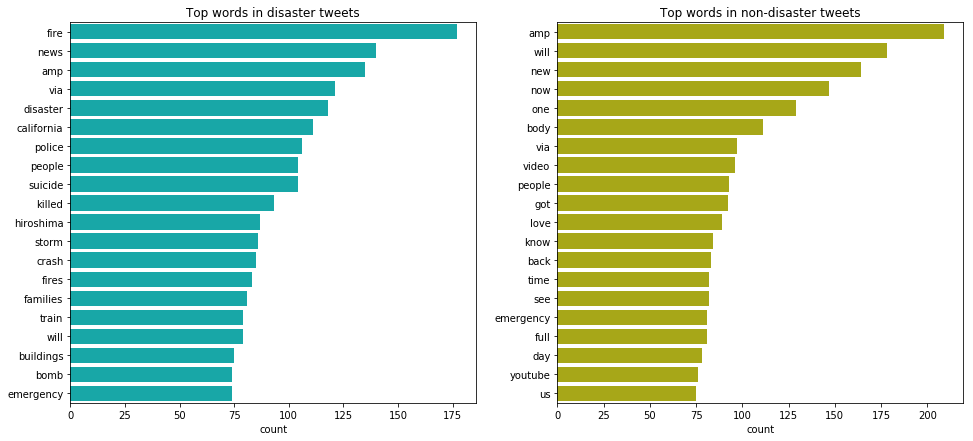

In [24]:
plt.figure(figsize=(16,7))
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(top20_d['count'], top20_d.index, color='c')
plt.title('Top words in disaster tweets')
plt.subplot(122)
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(top20_nd['count'], top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()

Findings:
- Top two words in disaster tweets: 'fire' and 'news', don't make the top 20 on unreal disaster tweets.
- Words are more specific for real disaster tweets (e.g. 'califonia', 'hiroshima', 'fire', 'police', 'suicide', 'bomb').

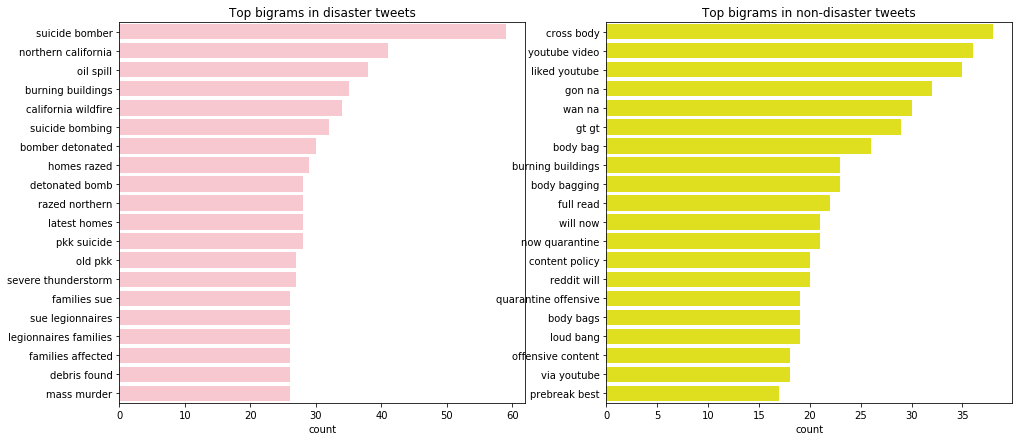

In [25]:
# Bigrams

from nltk import bigrams

plt.figure(figsize=(16,7))
plt.subplot(121)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='pink')
plt.title('Top bigrams in disaster tweets')
plt.subplot(122)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20], color='yellow')
plt.title('Top bigrams in non-disaster tweets')
plt.show()

Findings:
- Most top bigrams in disaster tweets show certain kinds of catestrophe (e.g. suicide bomber, oil spill, california wildfire); for non-disaster tweets, only 'burning buildings' as top bigram look like a disaster;
- Top bigrams in disaster tweets have a more casual tone;
- 'youtube' appears in three of the twenty bigrams for non-disaster tweets; none in disaster tweets

## 8. Encoding and Vectorizers

As part of feature generation, we will:
- Apply target encoding to keyword and location (cleaned)
- Count Vectorize cleaned text, links, hashtags and mentions columns

In [26]:
# ===========================================
# Disaster Tweets Upgraded (SAFE, no-leak)
#  - A-branch: Count → NBSVM reweight + SupervisedLexicon → LR
#  - B-branch: Word TF-IDF(1-3) + Char TF-IDF(3-5) + Meta + Disaster Lexicon → LR & Calibrated SVC
#  - Small C-grid per fold (select by OOF F1 with per-model best threshold)
#  - OOF weight blending & global threshold from OOF
# ===========================================

import os, re, gc, hashlib, random
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.sparse import hstack, csr_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer

RANDOM_SEED = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

# ---------- Load ----------
TRAIN_P = "/kaggle/input/nlp-getting-started/train.csv"
TEST_P  = "/kaggle/input/nlp-getting-started/test.csv"
SUB_P   = "/kaggle/input/nlp-getting-started/sample_submission.csv"

train = pd.read_csv(TRAIN_P)
test  = pd.read_csv(TEST_P)
sample_submission = pd.read_csv(SUB_P)

assert 'target' not in test.columns, "TEST SET에 target 컬럼이 있습니다. 라벨 누출!"

# ---------- Clean ----------
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+|www\.\S+", " ", text)    # URLs
    text = re.sub(r"@\w+", " ", text)                # @mentions
    text = re.sub(r"#([A-Za-z0-9_]+)", r"\1", text)  # #tag -> word
    text = re.sub(r"[^a-zA-Z\s]", " ", text)         # keep letters only
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

train["text_clean"] = train["text"].astype(str).apply(clean_text)
test["text_clean"]  = test["text"].astype(str).apply(clean_text)

# ---------- Light synonym-based augmentation (NO pseudo-labeling) ----------
def pseudo_back_translate(xs):
    out = []
    for s in xs:
        ws = s.split()
        k = 0 if len(ws) < 6 else min(3, len(ws)//6)  # up to ~15% tokens
        idxs = np.random.choice(range(len(ws)), size=k, replace=False) if k>0 else []
        ws2 = ws[:]
        for i in idxs:
            base = re.sub(r'[^a-zA-Z]', '', ws2[i]).lower()
            if not base: 
                continue
            syns = set()
            for ss in wn.synsets(base):
                if ss.pos() in ('a','s','r','v','n'):
                    for l in ss.lemmas():
                        w = l.name().replace('_',' ')
                        if w.isalpha() and 2 < len(w) < 20 and w.lower()!=base:
                            syns.add(w)
            if syns:
                ws2[i] = random.choice(list(syns))
        if random.random() < 0.2:
            ws2.append(random.choice(["!", "!!", "!?"]))
        out.append(" ".join(ws2))
    return out

bt_texts = pseudo_back_translate(train["text"].astype(str).tolist())
train_bt = pd.DataFrame({"text": bt_texts, "target": train["target"].values})
train_bt["text_clean"] = train_bt["text"].astype(str).apply(clean_text)

# ---------- Merge + de-dup + conflict removal ----------
tmp = pd.concat(
    [train[["text","target","text_clean"]],
     train_bt[["text","target","text_clean"]]],
    ignore_index=True
)

agg = tmp.groupby("text_clean")["target"].agg(['nunique','count','mean']).reset_index()
conflicts = set(agg.loc[agg['nunique'] > 1, 'text_clean'])
tmp = tmp[~tmp["text_clean"].isin(conflicts)].drop_duplicates(subset=["text_clean","target"])

def hash_id(s):
    return int(hashlib.md5(s.encode('utf-8')).hexdigest(), 16) % (10**9)

tmp["group_key"] = tmp["text_clean"].apply(hash_id)
train_aug = tmp.reset_index(drop=True)

# ---------- Transformers ----------
class NBSVMTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.r_ = None
    def fit(self, X, y):
        if not sparse.isspmatrix_csr(X): X = csr_matrix(X)
        X_pos = X[y == 1]; X_neg = X[y == 0]
        p = np.asarray(X_pos.sum(axis=0)).ravel() + self.alpha
        q = np.asarray(X_neg.sum(axis=0)).ravel() + self.alpha
        self.r_ = np.log(p / p.sum()) - np.log(q / q.sum())
        return self
    def transform(self, X):
        if not sparse.isspmatrix_csr(X): X = csr_matrix(X)
        return X @ sparse.diags(self.r_, shape=(X.shape[1], X.shape[1]))

class SupervisedLexicon(BaseEstimator, TransformerMixin):
    """
    Train-fold only log-odds r; build 7 summary features:
    [pos_sum, neg_sum, pos_cnt, neg_cnt, pos_ratio, signed_sum, tot_cnt]
    """
    def __init__(self, k_pos=8000, k_neg=8000, alpha=1.0, transform_mode="log1p"):
        self.k_pos = k_pos
        self.k_neg = k_neg
        self.alpha = alpha
        self.transform_mode = transform_mode
        self.pos_idx_ = None
        self.neg_idx_ = None
        self.r_ = None
        self.scaler_ = None

    def fit(self, X_counts_tr, y_tr):
        if not sparse.isspmatrix_csr(X_counts_tr): X_counts_tr = csr_matrix(X_counts_tr)
        X_pos = X_counts_tr[y_tr == 1]; X_neg = X_counts_tr[y_tr == 0]
        p = np.asarray(X_pos.sum(axis=0)).ravel() + self.alpha
        q = np.asarray(X_neg.sum(axis=0)).ravel() + self.alpha
        p /= p.sum(); q /= q.sum()
        r = np.log(p) - np.log(q)
        vocab_size = r.size
        k_pos = int(min(max(1, self.k_pos), vocab_size-1))
        k_neg = int(min(max(1, self.k_neg), vocab_size-1))
        self.pos_idx_ = np.unique(np.argpartition(-r, k_pos)[:k_pos])
        self.neg_idx_ = np.unique(np.argpartition( r, k_neg)[:k_neg])
        self.r_ = r
        return self

    def _featurize(self, Xc):
        pos_sum = np.asarray(Xc[:, self.pos_idx_] @ self.r_[self.pos_idx_]).ravel()
        neg_sum = np.asarray(Xc[:, self.neg_idx_] @ (-self.r_[self.neg_idx_])).ravel()
        pos_cnt = np.asarray(Xc[:, self.pos_idx_].sum(axis=1)).ravel()
        neg_cnt = np.asarray(Xc[:, self.neg_idx_].sum(axis=1)).ravel()
        tot_cnt = np.asarray(Xc.sum(axis=1)).ravel()
        pos_ratio = pos_cnt / np.maximum(pos_cnt + neg_cnt, 1)
        signed_sum = pos_sum - neg_sum
        if self.transform_mode == "log1p":
            pos_sum = np.log1p(np.maximum(pos_sum, 0))
            neg_sum = np.log1p(np.maximum(neg_sum, 0))
            signed_sum = np.sign(signed_sum) * np.log1p(np.abs(signed_sum))
            pos_cnt = np.log1p(pos_cnt); neg_cnt = np.log1p(neg_cnt); tot_cnt = np.log1p(tot_cnt)
        elif self.transform_mode == "sqrt":
            pos_sum = np.sqrt(np.maximum(pos_sum, 0))
            neg_sum = np.sqrt(np.maximum(neg_sum, 0))
            signed_sum = np.sign(signed_sum) * np.sqrt(np.abs(signed_sum))
            pos_cnt = np.sqrt(pos_cnt); neg_cnt = np.sqrt(neg_cnt); tot_cnt = np.sqrt(tot_cnt)
        feats = np.vstack([pos_sum, neg_sum, pos_cnt, neg_cnt, pos_ratio, signed_sum, tot_cnt]).T
        return feats

    def fit_transform(self, X_counts_tr, y_tr):
        self.fit(X_counts_tr, y_tr)
        feats_tr = self._featurize(X_counts_tr)
        self.scaler_ = StandardScaler().fit(feats_tr)
        feats_tr = self.scaler_.transform(feats_tr)
        return feats_tr

    def transform(self, X_counts_eval):
        feats = self._featurize(X_counts_eval)
        return self.scaler_.transform(feats)

# ---------- Disaster lexicon (fixed list; meta features) ----------
DISASTER_LEX = [
    "fire","earthquake","flood","disaster","crash","storm","hurricane",
    "tornado","explosion","bomb","evacuate","evacuation","shelter",
    "collapse","damage","emergency","rescue","tsunami","survivor"
]

def build_lexicon_meta(texts):
    """Return sparse matrix of [has_w ...] + [count_all] for DISASTER_LEX and simple length meta."""
    has_feats = []
    for w in DISASTER_LEX:
        pattern = re.compile(rf"\b{re.escape(w)}\b")
        has_feats.append(np.array([1 if pattern.search(t) else 0 for t in texts], dtype=np.int32))
    has_mat = np.vstack(has_feats).T  # shape: (n, len(LEX))
    count_all = has_mat.sum(axis=1).reshape(-1,1)
    length = np.array([len(s) for s in texts]).reshape(-1,1)
    meta = np.hstack([has_mat, count_all, length])  # binary per-word + total + length
    return csr_matrix(meta)

# ---------- Helpers ----------
def best_f1_threshold(y_true, prob):
    p, r, thr = precision_recall_curve(y_true, prob)
    f1s = 2*p*r / (p + r + 1e-12)
    i = np.nanargmax(f1s)
    th = thr[i] if i < len(thr) else 0.5
    return f1s[i], th

def pick_best_by_f1(y_va, prob_dict):
    """prob_dict: name -> prob array (validation). Returns best_name, best_probs, best_F1, best_th."""
    best = (-1, None, None, None)
    for name, pr in prob_dict.items():
        f1, th = best_f1_threshold(y_va, pr)
        if f1 > best[0]:
            best = (f1, name, pr, th)
    return best  # f1, name, probs, th

# ---------- GroupKFold ----------
groups = train_aug["group_key"].values
y_all  = train_aug["target"].values
texts_all = train_aug["text_clean"].values
gkf = GroupKFold(n_splits=5)

# OOF / TEST containers
oof_A = np.zeros(len(y_all))
test_A = np.zeros(len(test))
oof_B_lr  = np.zeros(len(y_all))
oof_B_svc = np.zeros(len(y_all))
test_B_lr  = np.zeros(len(test))
test_B_svc = np.zeros(len(test))

for fold, (tr_idx, va_idx) in enumerate(gkf.split(train_aug, y_all, groups=groups), 1):
    print(f"[Fold {fold}] train={len(tr_idx)}, valid={len(va_idx)}")
    X_tr_texts = texts_all[tr_idx]
    X_va_texts = texts_all[va_idx]
    y_tr = y_all[tr_idx]; y_va = y_all[va_idx]

    # ======== A-branch: Count → NBSVM + SupervisedLexicon → LR (with small C-grid) ========
    cv = CountVectorizer(min_df=3, ngram_range=(1,3), strip_accents='unicode', lowercase=True)
    X_tr_counts = cv.fit_transform(X_tr_texts)
    X_va_counts = cv.transform(X_va_texts)
    X_te_counts = cv.transform(test["text_clean"].values)

    nbsvm = NBSVMTransformer(alpha=1.0).fit(X_tr_counts, y_tr)
    X_tr_nb = nbsvm.transform(X_tr_counts)
    X_va_nb = nbsvm.transform(X_va_counts)
    X_te_nb = nbsvm.transform(X_te_counts)

    lex = SupervisedLexicon(k_pos=8000, k_neg=8000, alpha=1.0, transform_mode="log1p")
    X_tr_lex = lex.fit_transform(X_tr_counts, y_tr)
    X_va_lex = lex.transform(X_va_counts)
    X_te_lex = lex.transform(X_te_counts)

    X_tr_A = hstack([X_tr_nb, csr_matrix(X_tr_lex)], format='csr')
    X_va_A = hstack([X_va_nb, csr_matrix(X_va_lex)], format='csr')
    X_te_A = hstack([X_te_nb, csr_matrix(X_te_lex)], format='csr')

    # small grid for C
    C_list_A = [2.0, 4.0, 8.0]
    cand_prob_A = {}
    clfs_A = {}
    for Cval in C_list_A:
        clf_A = LogisticRegression(C=Cval, solver="liblinear", max_iter=1000,
                                   class_weight='balanced', random_state=RANDOM_SEED)
        clf_A.fit(X_tr_A, y_tr)
        prob_va = clf_A.predict_proba(X_va_A)[:,1]
        cand_prob_A[f"LR_A_C{Cval}"] = prob_va
        clfs_A[f"LR_A_C{Cval}"] = clf_A
    f1A, nameA, best_prob_A, thA = pick_best_by_f1(y_va, cand_prob_A)
    oof_A[va_idx] = best_prob_A
    test_A += clfs_A[nameA].predict_proba(X_te_A)[:,1] / gkf.n_splits

    # ======== B-branch: TF-IDF word+char + meta(lexicon 포함) → LR & Calibrated SVC ========
    tfidf_w = TfidfVectorizer(min_df=3, max_df=0.95, ngram_range=(1,3),
                              sublinear_tf=True, strip_accents='unicode')
    Xw_tr = tfidf_w.fit_transform(X_tr_texts)
    Xw_va = tfidf_w.transform(X_va_texts)
    Xw_te = tfidf_w.transform(test["text_clean"].values)

    tfidf_c = TfidfVectorizer(analyzer='char', ngram_range=(3,5),
                              min_df=3, sublinear_tf=True)
    Xc_tr = tfidf_c.fit_transform(X_tr_texts)
    Xc_va = tfidf_c.transform(X_va_texts)
    Xc_te = tfidf_c.transform(test["text_clean"].values)

    meta_tr = build_lexicon_meta(X_tr_texts)   # DISASTER_LEX binary + total + length
    meta_va = build_lexicon_meta(X_va_texts)
    meta_te = build_lexicon_meta(test["text_clean"].values)

    X_tr_B = hstack([Xw_tr, Xc_tr, meta_tr]).tocsr()
    X_va_B = hstack([Xw_va, Xc_va, meta_va]).tocsr()
    X_te_B = hstack([Xw_te, Xc_te, meta_te]).tocsr()

    # (B1) LR with small C-grid
    C_list_B_LR = [2.0, 4.0, 8.0]
    cand_prob_B_lr, clfs_B_lr = {}, {}
    for Cval in C_list_B_LR:
        clf_B_lr = LogisticRegression(C=Cval, max_iter=1000, class_weight='balanced', n_jobs=-1)
        clf_B_lr.fit(X_tr_B, y_tr)
        prob_va = clf_B_lr.predict_proba(X_va_B)[:,1]
        cand_prob_B_lr[f"LR_B_C{Cval}"] = prob_va
        clfs_B_lr[f"LR_B_C{Cval}"] = clf_B_lr
    f1BLR, nameBLR, best_prob_B_lr, thBLR = pick_best_by_f1(y_va, cand_prob_B_lr)
    oof_B_lr[va_idx] = best_prob_B_lr
    test_B_lr += clfs_B_lr[nameBLR].predict_proba(X_te_B)[:,1] / gkf.n_splits

    # (B2) Calibrated LinearSVC with small C-grid
    C_list_B_SVC = [0.5, 1.0, 2.0]
    cand_prob_B_svc, clfs_B_svc = {}, {}
    for Cval in C_list_B_SVC:
        base_svc = LinearSVC(C=Cval, class_weight='balanced')
        clf_B_svc = CalibratedClassifierCV(base_svc, method='sigmoid', cv=3)
        clf_B_svc.fit(X_tr_B, y_tr)
        prob_va = clf_B_svc.predict_proba(X_va_B)[:,1]
        cand_prob_B_svc[f"SVC_B_C{Cval}"] = prob_va
        clfs_B_svc[f"SVC_B_C{Cval}"] = clf_B_svc
    f1BSVC, nameBSVC, best_prob_B_svc, thBSVC = pick_best_by_f1(y_va, cand_prob_B_svc)
    oof_B_svc[va_idx] = best_prob_B_svc
    test_B_svc += clfs_B_svc[nameBSVC].predict_proba(X_te_B)[:,1] / gkf.n_splits

    # cleanup
    del X_tr_counts, X_va_counts, X_te_counts, X_tr_nb, X_va_nb, X_te_nb
    del X_tr_lex, X_va_lex, X_te_lex, X_tr_A, X_va_A, X_te_A
    del Xw_tr, Xw_va, Xw_te, Xc_tr, Xc_va, Xc_te, meta_tr, meta_va, meta_te, X_tr_B, X_va_B, X_te_B
    gc.collect()

# ---------- OOF weight blending (grid) & global threshold ----------
def oof_blend_search(oof_A, oof_B_lr, oof_B_svc, y_true):
    best = (-1, None, None)
    grid = np.linspace(0.1, 0.8, 8)
    for wA in grid:
        for wLR in grid:
            wSVC = 1.0 - (wA + wLR)
            if wSVC <= 0 or wSVC >= 0.9: 
                continue
            oof_blend = wA*oof_A + wLR*oof_B_lr + wSVC*oof_B_svc
            f1, th = best_f1_threshold(y_true, oof_blend)
            if f1 > best[0]:
                best = (f1, (wA, wLR, wSVC), th)
    return best

best_f1, (wA, wLR, wSVC), best_th = oof_blend_search(oof_A, oof_B_lr, oof_B_svc, y_all)
print(f"\n[BLEND] OOF F1={best_f1:.4f} with weights A={wA:.2f}, LR={wLR:.2f}, SVC={wSVC:.2f} @thr={best_th:.4f}")

# ---------- Predict test ----------
test_blend = wA*test_A + wLR*test_B_lr + wSVC*test_B_svc
test_pred = (test_blend >= best_th).astype(int)

submission = sample_submission.copy()
submission["target"] = test_pred
submission.to_csv("submission_nbsvm_tfidf_lexicon_blend_SAFE.csv", index=False)
print("\nSaved: submission_nbsvm_tfidf_lexicon_blend_SAFE.csv")



[Fold 1] train=9853, valid=2464


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number o

[Fold 2] train=9853, valid=2464


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number o

[Fold 3] train=9854, valid=2463


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number o

[Fold 4] train=9854, valid=2463


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number o

[Fold 5] train=9854, valid=2463


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number o


[BLEND] OOF F1=0.8655 with weights A=0.10, LR=0.80, SVC=0.10 @thr=0.4809

Saved: submission_nbsvm_tfidf_lexicon_blend_SAFE.csv
